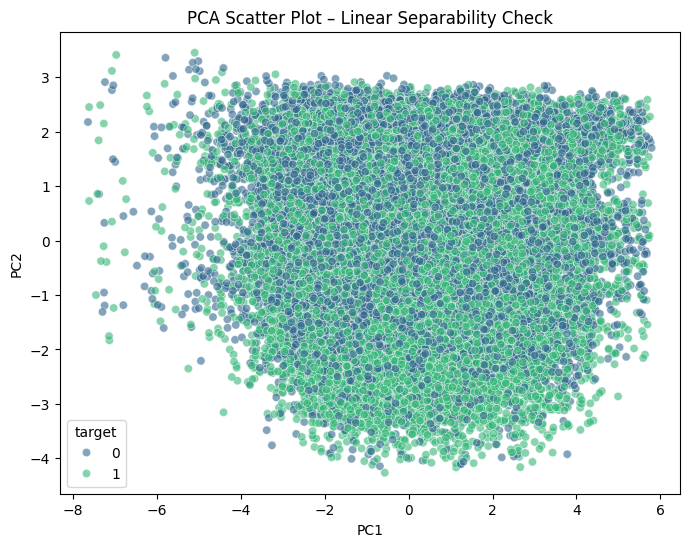

Running t-SNE... may take 30–60 sec...


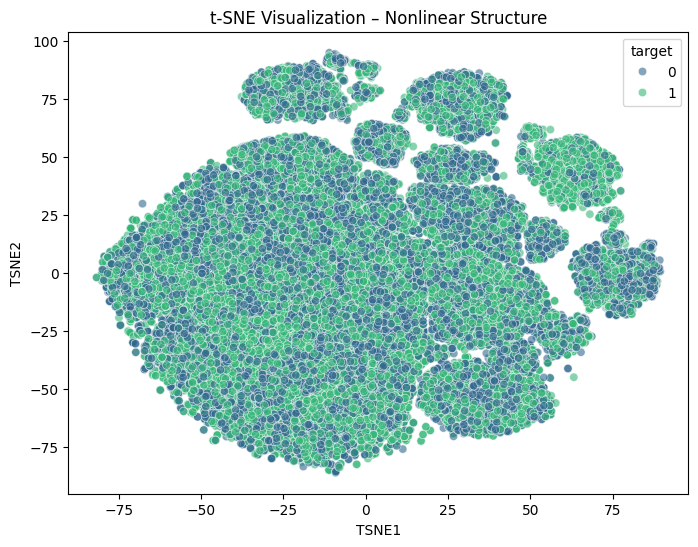

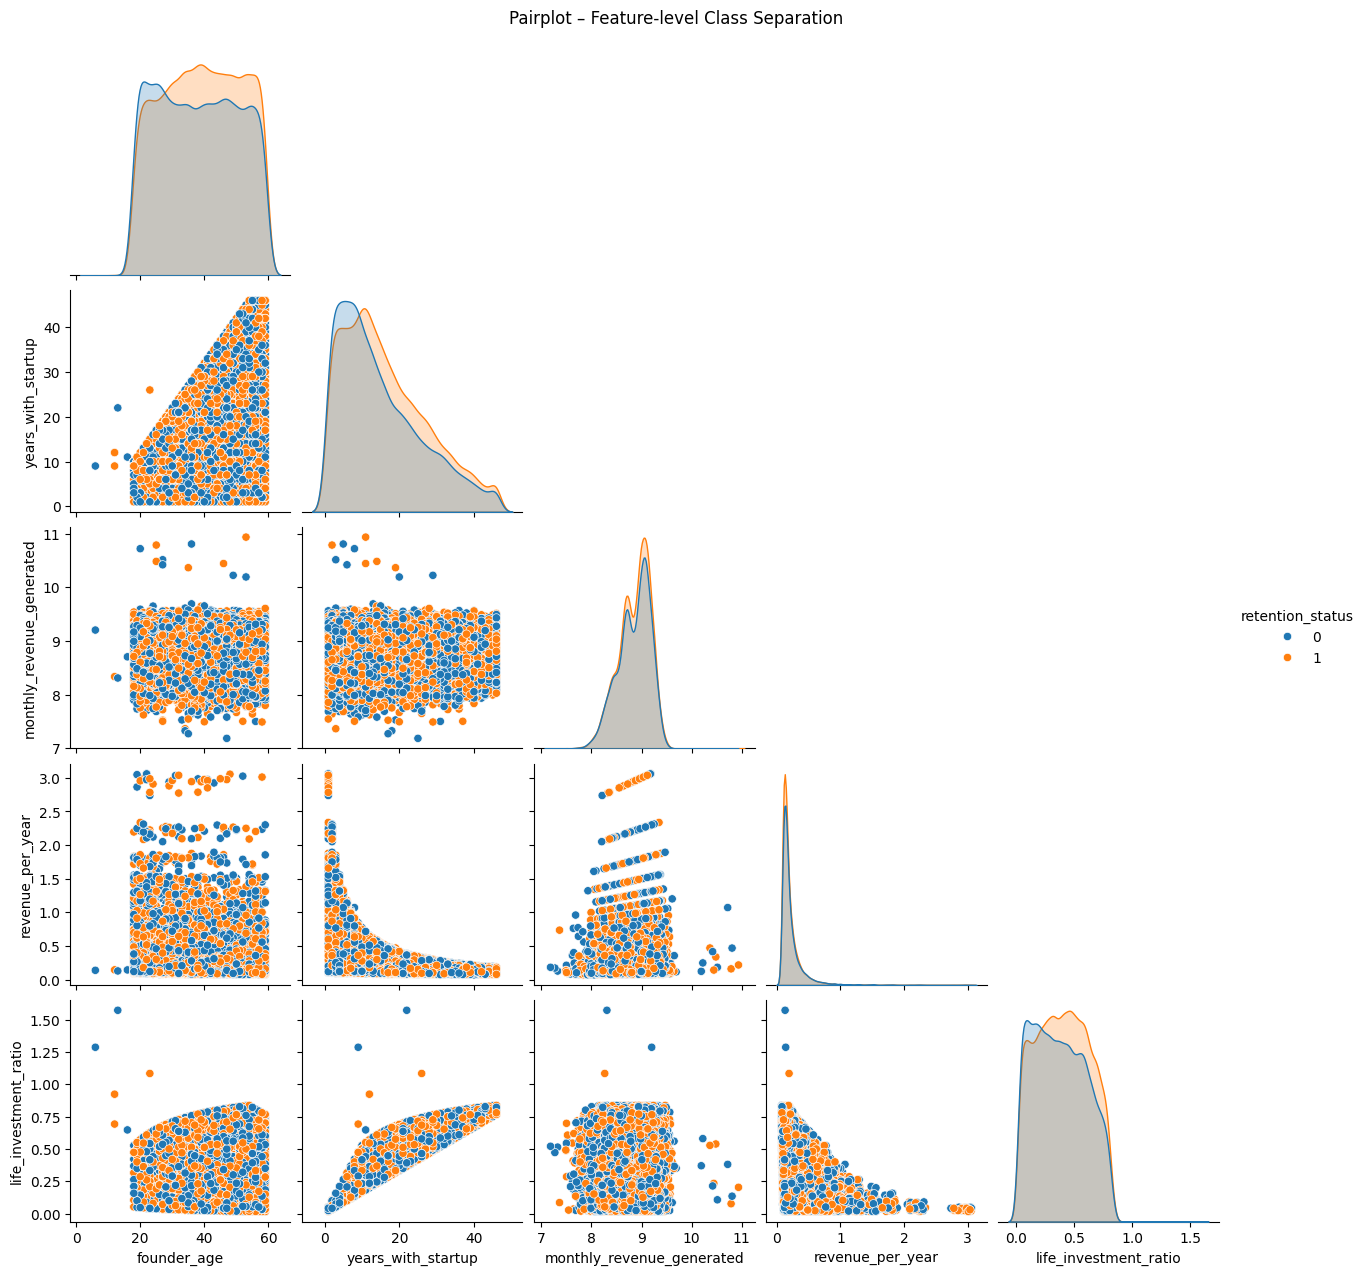

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Encode target into numerical (0 = Left, 1 = Stayed)
train['retention_status'] = train['retention_status'].map({"Stayed": 1, "Left": 0}).astype(int)

TARGET = "retention_status"
ID_COL = "founder_id"

for df in [train, test]:

    # Fill important column
    df["years_since_founding"] = df["years_since_founding"].fillna(
        df["years_since_founding"].median()
    )

    # Engineered features
    df["revenue_per_year"] = df["monthly_revenue_generated"] / (df["years_since_founding"] + 1)
    df["life_investment_ratio"] = df["years_with_startup"] / (df["founder_age"] + 1)
    df["age_at_founding"] = df["founder_age"] - df["years_with_startup"]
    df["revenue_per_round"] = df["monthly_revenue_generated"] / (df["funding_rounds_led"] + 1)

    # Interaction features
    df["commitment_x_team"] = (
        df["years_with_startup"] * df["team_size_category"].astype("category").cat.codes
    )
    df["satisfaction_x_balance"] = (
        df["venture_satisfaction"].astype("category").cat.codes *
        df["work_life_balance_rating"].astype("category").cat.codes
    )


X = train.drop(columns=[TARGET, ID_COL, "founder_visibility"])
y = train[TARGET].values

X_test = test.drop(columns=[ID_COL, "founder_visibility"], errors="ignore")

# Identify categorical columns for CatBoost
cat_cols = X.select_dtypes(include="object").columns.tolist()

# Ensure all categorical are strings
for col in cat_cols:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

cat_model = CatBoostClassifier(
    iterations=700,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=4,
    loss_function="Logloss",
    verbose=False,
    random_state=42
)

cat_model.fit(X, y, cat_features=cat_cols)

#  EXTRACT NONLINEAR LEAF EMBEDDINGS
X_leaf = cat_model.calc_leaf_indexes(X)
X_test_leaf = cat_model.calc_leaf_indexes(X_test)

X_leaf = np.array(X_leaf)
X_test_leaf = np.array(X_test_leaf)


# SCALE THE LEAF EMBEDDINGS
scaler = RobustScaler()
X_leaf_scaled = scaler.fit_transform(X_leaf)
X_test_leaf_scaled = scaler.transform(X_test_leaf)


# TRAIN LINEAR SVM ON EMBEDDINGS
svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=7000,
    dual=False,
    random_state=42
)

svm.fit(X_leaf_scaled, y)


# PREDICT ON TEST USING SVM
decision = svm.decision_function(X_test_leaf_scaled)
probs = 1 / (1 + np.exp(-decision))
labels = np.where(probs >= 0.5, "Stayed", "Left")

# SUBMISSION
submission = pd.DataFrame({
    "founder_id": test["founder_id"],
    "retention_status": labels
})

submission.to_csv("submission_catboost_leaf_svm.csv", index=False)
print(" Saved submission_catboost_leaf_svm.csv")
